# Binary Classification Model for Springleaf Marketing Response Using TensorFlow Take 4
### David Lowe
### March 20, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Springleaf Marketing Response dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Springleaf leverages the direct mail method for connecting with customers who may need a loan. To improve their targeting efforts, Springleaf must be sure they are focusing on the customers who are likely to respond and be good candidates for their services. Using a dataset with a broad set of anonymized features, Springleaf is looking to predict which customers will respond to a direct mail offer.

In iteration Take1, we constructed several traditional machine learning models using the linear, non-linear, and ensemble techniques. We also observed the best ROC-AUC result that we could obtain with each of these models.

In iteration Take2, we constructed and tuned an XGBoost machine learning model for this dataset. We also observed the best ROC-AUC result that we could obtain with the XGBoost model.

In iteration Take3, we constructed several Multilayer Perceptron (MLP) models with one hidden layer of 64, 128, 256, 512, 1024, and 2048 nodes. These single-layer MLP models serve as the baseline models as we build more complex MLP models in future iterations.

In this Take4 iteration, we will construct several Multilayer Perceptron (MLP) models with two hidden layers. We will observe whether these two-layer MLP models can improve the AUC-ROC performance of the single-layer models.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average ROC-AUC of 70.42%. The Random Forest and Gradient Boosting Machine algorithms made the top ROC-AUC metrics after the first round of modeling. After a series of tuning trials, GBM turned in an overall ROC-AUC result of 77.96%. When we apply the tuned GBM algorithm to the test dataset, we obtained a ROC-AUC score of only 62.58%, which was much lower than the score from model training.

In iteration Take2, the XGBoost algorithm achieved a baseline ROC-AUC performance of 77.08%. After a series of tuning trials, XGBoost turned in an overall best ROC-AUC result of 78.23%. When we apply the tuned XGBoost algorithm to the test dataset, we obtained a ROC-AUC score of only 62.86%, which was much lower than the score from model training.

In iteration Take3, all one-layer models achieved a ROC-AUC performance of around 50%.

In this Take4 iteration, all two-layer models again achieved a ROC-AUC performance of around 50%. 

CONCLUSION: For this iteration, all two-layer models scored poorly on the ROC-AUC performance. For this dataset, we should consider doing more modeling and tuning with more complex MLP models.

Dataset Used: Springleaf Marketing Response Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/springleaf-marketing-response/data

One potential source of performance benchmark: https://www.kaggle.com/c/springleaf-marketing-response/leaderboard

Any deep-learning modeling project genrally can be broken down into about six major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Mar 17 16:11:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [6]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.15

# Set various default Keras modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = [tf.keras.metrics.AUC()]
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_epoch = 20
default_batch = 32

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-springleaf-marketing-response/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', na_values=["NA"," [] ",""], true_values=["true"], false_values=["false"])

# Take a peek at the dataframe after the import
Xy_original.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0029,VAR_0030,VAR_0031,VAR_0032,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,...,VAR_1896,VAR_1897,VAR_1898,VAR_1899,VAR_1900,VAR_1901,VAR_1902,VAR_1903,VAR_1904,VAR_1905,VAR_1906,VAR_1907,VAR_1908,VAR_1909,VAR_1910,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,997,997,997,147,198,173,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,False,False,False,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,49,49,3,21,12,2,2,0,2,0,0,0,0,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,997,997,45,46,46,1,0,0,3,0,97,0,97,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120,30,996,996,15,188,106,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30,1,17,17,76,443,230,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,BRANCH,1
5,14,R,4,4,4422,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,998,998,998,9998,9998,9998,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
6,16,H,60,132,40000,C,1.0,1.0,False,False,False,False,False,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,...,1,1,997,997,69,215,139,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,1,0,1,0,999999996,400,400,9996,76,IAPS,1
7,20,R,13,75,3600,B,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60,60,70,70,14,14,14,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
8,21,R,17,16,2296,N,1.0,1.0,False,False,False,False,False,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,400,120,83,83,58,90,80,0,0,0,19,0,0,0,0,0,999999996,33459,999999996,999999996,1,1,9996,35,0,98,999999998,999999998,9998,1,0,97,997,999999997,400,997,9996,90,MOBILE,1
9,22,R,24,72,450,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.

In [12]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Data columns (total 1934 columns):
ID          int64
VAR_0001    object
VAR_0002    int64
VAR_0003    int64
VAR_0004    int64
VAR_0005    object
VAR_0006    float64
VAR_0007    float64
VAR_0008    object
VAR_0009    object
VAR_0010    object
VAR_0011    object
VAR_0012    object
VAR_0013    float64
VAR_0014    float64
VAR_0015    float64
VAR_0016    float64
VAR_0017    float64
VAR_0018    float64
VAR_0019    float64
VAR_0020    float64
VAR_0021    float64
VAR_0022    float64
VAR_0023    float64
VAR_0024    float64
VAR_0025    float64
VAR_0026    float64
VAR_0027    float64
VAR_0028    float64
VAR_0029    float64
VAR_0030    float64
VAR_0031    float64
VAR_0032    float64
VAR_0033    float64
VAR_0034    float64
VAR_0035    float64
VAR_0036    float64
VAR_0037    float64
VAR_0038    float64
VAR_0039    float64
VAR_0040    float64
VAR_0041    float64
VAR_0042    float64
VAR_0043    object
VAR_0044    object
VAR_

In [13]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

VAR_0006        56
VAR_0007        56
VAR_0008        56
VAR_0009        56
VAR_0010        56
             ...  
VAR_0528       918
VAR_0529       917
VAR_0530       918
VAR_0531       917
VAR_0840    145231
Length: 525, dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  3511742


## 1.b) Data Cleaning

In [0]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'target': 'targetVar'})

In [0]:
# Impute missing values
Xy_original.dropna(subset=['VAR_0008', 'VAR_0090', 'VAR_0242', 'VAR_0200', 'VAR_0350'], inplace=True)

In [0]:
# Dropping features due to too many missing values in the columns
Xy_original.drop(columns=['VAR_0073', 'VAR_0074'], inplace=True)
Xy_original.drop(columns=['VAR_0156', 'VAR_0157', 'VAR_0158', 'VAR_0159'], inplace=True)
Xy_original.drop(columns=['VAR_0166', 'VAR_0167', 'VAR_0168', 'VAR_0169'], inplace=True)
Xy_original.drop(columns=['VAR_0176', 'VAR_0177', 'VAR_0178', 'VAR_0179'], inplace=True)
Xy_original.drop(columns=['VAR_0205', 'VAR_0206', 'VAR_0207', 'VAR_0208', 'VAR_0209'], inplace=True)
Xy_original.drop(columns=['VAR_0210', 'VAR_0211', 'VAR_0212', 'VAR_0213', 'VAR_0214'], inplace=True)
Xy_original.drop(columns=['VAR_0840'], inplace=True)

In [0]:
# Dropping features due to non-predictive nature of the columns
Xy_original.drop(columns=['ID'], inplace=True)
Xy_original.drop(columns=['VAR_0008', 'VAR_0009', 'VAR_0010', 'VAR_0011', 'VAR_0012'], inplace=True)
Xy_original.drop(columns=['VAR_0018', 'VAR_0019', 'VAR_0020', 'VAR_0021', 'VAR_0022'], inplace=True)
Xy_original.drop(columns=['VAR_0023', 'VAR_0024', 'VAR_0025', 'VAR_0026', 'VAR_0027'], inplace=True)
Xy_original.drop(columns=['VAR_0028', 'VAR_0029', 'VAR_0030', 'VAR_0031', 'VAR_0032'], inplace=True)
Xy_original.drop(columns=['VAR_0038', 'VAR_0039', 'VAR_0040', 'VAR_0041', 'VAR_0042'], inplace=True)
Xy_original.drop(columns=['VAR_0043', 'VAR_0044', 'VAR_0075'], inplace=True)
Xy_original.drop(columns=['VAR_0188', 'VAR_0189', 'VAR_0190'], inplace=True)
Xy_original.drop(columns=['VAR_0196', 'VAR_0197', 'VAR_0199'], inplace=True)
Xy_original.drop(columns=['VAR_0200', 'VAR_0202', 'VAR_0203', 'VAR_0204'], inplace=True)
Xy_original.drop(columns=['VAR_0215', 'VAR_0216', 'VAR_0217'], inplace=True)
Xy_original.drop(columns=['VAR_0221', 'VAR_0222', 'VAR_0223'], inplace=True)
Xy_original.drop(columns=['VAR_0229', 'VAR_0239', 'VAR_0246'], inplace=True)
Xy_original.drop(columns=['VAR_0394', 'VAR_0404', 'VAR_0438'], inplace=True)
Xy_original.drop(columns=['VAR_0493'], inplace=True)
Xy_original.drop(columns=['VAR_0527', 'VAR_0528', 'VAR_0530'], inplace=True)
Xy_original.drop(columns=['VAR_0847'], inplace=True)
Xy_original.drop(columns=['VAR_1428'], inplace=True)

In [0]:
# Convert columns from one data type to another
Xy_original['VAR_0001'] = Xy_original['VAR_0001'].astype('category')
Xy_original['VAR_0005'] = Xy_original['VAR_0005'].astype('category')
# Xy_original['VAR_0226'] = Xy_original['VAR_0226'].astype('bool')
# Xy_original['VAR_0230'] = Xy_original['VAR_0230'].astype('bool')
# Xy_original['VAR_0232'] = Xy_original['VAR_0232'].astype('bool')
# Xy_original['VAR_0236'] = Xy_original['VAR_0236'].astype('bool')
Xy_original['VAR_0226'] = Xy_original['VAR_0226'].astype('category')
Xy_original['VAR_0230'] = Xy_original['VAR_0230'].astype('category')
Xy_original['VAR_0232'] = Xy_original['VAR_0232'].astype('category')
Xy_original['VAR_0236'] = Xy_original['VAR_0236'].astype('category')
Xy_original['VAR_0237'] = Xy_original['VAR_0237'].astype('category')
Xy_original['VAR_0274'] = Xy_original['VAR_0274'].astype('category')
Xy_original['VAR_0283'] = Xy_original['VAR_0283'].astype('category')
Xy_original['VAR_0305'] = Xy_original['VAR_0305'].astype('category')
Xy_original['VAR_0325'] = Xy_original['VAR_0325'].astype('category')
Xy_original['VAR_0342'] = Xy_original['VAR_0342'].astype('category')
Xy_original['VAR_0352'] = Xy_original['VAR_0352'].astype('category')
Xy_original['VAR_0353'] = Xy_original['VAR_0353'].astype('category')
Xy_original['VAR_0354'] = Xy_original['VAR_0354'].astype('category')
Xy_original['VAR_0466'] = Xy_original['VAR_0466'].astype('category')
Xy_original['VAR_0467'] = Xy_original['VAR_0467'].astype('category')
Xy_original['VAR_1934'] = Xy_original['VAR_0467'].astype('category')

In [20]:
# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0057,VAR_0058,VAR_0059,VAR_0060,VAR_0061,VAR_0062,VAR_0063,VAR_0064,VAR_0065,VAR_0066,VAR_0067,...,VAR_1896,VAR_1897,VAR_1898,VAR_1899,VAR_1900,VAR_1901,VAR_1902,VAR_1903,VAR_1904,VAR_1905,VAR_1906,VAR_1907,VAR_1908,VAR_1909,VAR_1910,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,targetVar
0,H,224,0,4300,C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,997,997,997,147,198,173,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
1,H,7,53,4448,B,1.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,0.0,0.0,...,1,1,49,49,3,21,12,2,2,0,2,0,0,0,0,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,Discharged,0
2,H,116,3,3464,C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,1,997,997,45,46,46,1,0,0,3,0,97,0,97,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
3,H,240,300,3200,C,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,120,30,996,996,15,188,106,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
4,R,72,261,2000,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,30,1,17,17,76,443,230,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,1
5,R,4,4,4422,C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,998,998,998,998,9998,9998,9998,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
6,H,60,132,40000,C,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,...,1,1,997,997,69,215,139,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,1,0,1,0,999999996,400,400,9996,76,-1,1
7,R,13,75,3600,B,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,60,60,70,70,14,14,14,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
8,R,17,16,2296,N,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,...,400,120,83,83,58,90,80,0,0,0,19,0,0,0,0,0,999999996,33459,999999996,999999996,1,1,9996,35,0,98,999999998,999999998,9998,1,0,97,997,999999997,400,997,9996,90,-1,1
9,R,24,72,450,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,1,102,102,28,28,28,0,0,0,15,0,0,0,0,0,999999996,40060,999999996,999999996

In [21]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144262 entries, 0 to 145230
Data columns (total 1852 columns):
VAR_0001     category
VAR_0002     int64
VAR_0003     int64
VAR_0004     int64
VAR_0005     category
VAR_0006     float64
VAR_0007     float64
VAR_0013     float64
VAR_0014     float64
VAR_0015     float64
VAR_0016     float64
VAR_0017     float64
VAR_0033     float64
VAR_0034     float64
VAR_0035     float64
VAR_0036     float64
VAR_0037     float64
VAR_0045     float64
VAR_0046     float64
VAR_0047     float64
VAR_0048     float64
VAR_0049     float64
VAR_0050     float64
VAR_0051     float64
VAR_0052     float64
VAR_0053     float64
VAR_0054     float64
VAR_0055     float64
VAR_0056     float64
VAR_0057     float64
VAR_0058     float64
VAR_0059     float64
VAR_0060     float64
VAR_0061     float64
VAR_0062     float64
VAR_0063     float64
VAR_0064     float64
VAR_0065     float64
VAR_0066     float64
VAR_0067     float64
VAR_0068     float64
VAR_0069     float64
VAR_0070 

In [22]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [23]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [25]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (144262, 1852) X_original.shape: (144262, 1851) y_original.shape: (144262,)


### 1.d) Set up the parameters for data visualization

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [0]:
# Histograms for each attribute before pre-processing
# X_original.hist(layout=(dispRow,dispCol))
# plt.show()

In [0]:
# tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
# print(tobe_transformed_cols)

In [0]:
# Apply feature scaling and transformation
# X_original = X_original.astype(float)
# scaler = preprocessing.StandardScaler()
# X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

# X_original.head(-10)

In [0]:
# Histograms for each attribute after pre-processing
# X_original.hist(layout=(dispRow,dispCol))
# plt.show()

In [31]:
Xy_original.groupby('targetVar').size()

targetVar
0    110718
1     33544
dtype: int64

In [32]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144262 entries, 0 to 145230
Data columns (total 2046 columns):
VAR_0002                 int64
VAR_0003                 int64
VAR_0004                 int64
VAR_0006                 float64
VAR_0007                 float64
VAR_0013                 float64
VAR_0014                 float64
VAR_0015                 float64
VAR_0016                 float64
VAR_0017                 float64
VAR_0033                 float64
VAR_0034                 float64
VAR_0035                 float64
VAR_0036                 float64
VAR_0037                 float64
VAR_0045                 float64
VAR_0046                 float64
VAR_0047                 float64
VAR_0048                 float64
VAR_0049                 float64
VAR_0050                 float64
VAR_0051                 float64
VAR_0052                 float64
VAR_0053                 float64
VAR_0054                 float64
VAR_0055                 float64
VAR_0056                 float64
VA

## 1.d) Splitting Data into Training and Test Sets

In [33]:
# Encode class values as integers and perform one-hot-encoding
y_encoded = y_original.to_numpy()
# encoder = preprocessing.LabelEncoder()
# encoder.fit(y_original)
# y_encoded = encoder.transform(y_original)
print(y_encoded)

[0 0 0 ... 0 0 0]


In [34]:
# Split the data further into training and test datasets
X_encoded = X_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, 
                                                        stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (122622, 2046) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (122622,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (21640, 2046) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (21640,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Explore Different Two-Layer Models

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
# Define MLP model #4A
def create_model_4A():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(48, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4A = create_model_4A()
extra_epochs = 0
baseline_hist = baseline_model_4A.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 4A processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 122622 samples, validate on 21640 samples
Epoch 1/20
122622/122622 [==============================] - 15s 119us/sample - loss: 68696.5730 - auc: 0.5184 - val_loss: 69.8290 - val_auc: 0.5000
Epoch 2/20
122622/122622 [==============================] - 14s 115us/sample - loss: 27.2376 - auc: 0.5025 - val_loss: 8.3473 - val_auc: 0.5001
Epoch 3/20
122622/122622 [==============================] - 14s 114us/sample - loss: 0.6017 - auc: 0.4999 - val_loss: 7.2848 - val_auc: 0.5001
Epoch 4/20
122622/122622 [==============================] - 14s 113us/sample - loss: 0.5422 - auc: 0.4978 - val_loss: 7.2849 - val_auc: 0.5001
Epoch 5/20
122622/122622 [==============================] - 14s 114us/sample - loss: 0.5422 - auc: 0.4997 - val_loss: 7.2880 - val_auc: 0.5001
Epoch 6/20
122622/122622 [==============================] - 14s 114us/sample - loss: 0.5422 - auc: 0.4982 - val_loss: 7.2904 - val_auc: 0.5001
Epoch 7/20
122622/122622 [==============================] - 14s 113us/sample - loss: 

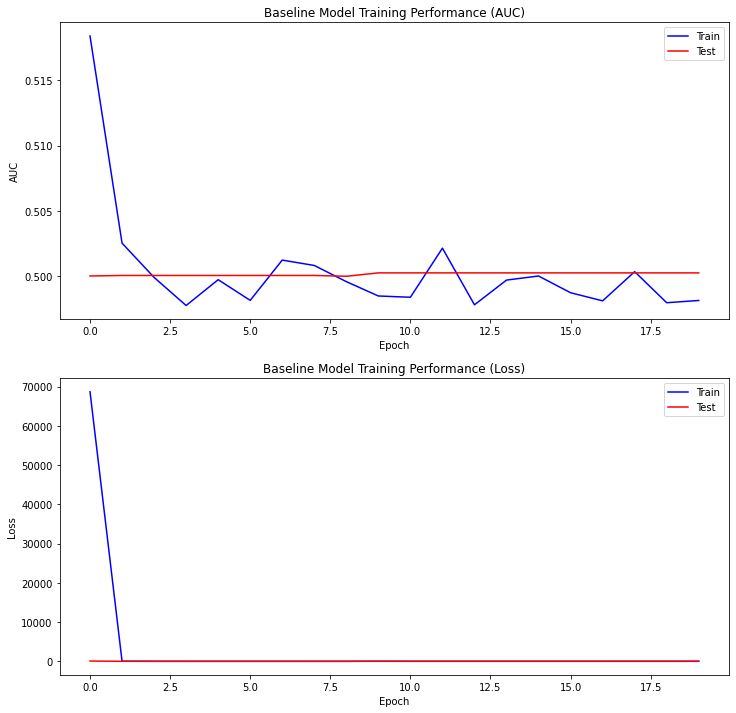

In [44]:
# Summarize model 4A training hisotry
begin_epoch = 0
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['auc'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_auc'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (AUC)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [45]:
# Define MLP model #4B
def create_model_4B():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(96, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4B = create_model_4B()
extra_epochs = 0
baseline_hist = baseline_model_4B.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 4B processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 122622 samples, validate on 21640 samples
Epoch 1/20
122622/122622 [==============================] - 15s 126us/sample - loss: 314721.5335 - auc: 0.5180 - val_loss: 37.0252 - val_auc: 0.4977
Epoch 2/20
122622/122622 [==============================] - 14s 118us/sample - loss: 21.6944 - auc: 0.5029 - val_loss: 10.0262 - val_auc: 0.5004
Epoch 3/20
122622/122622 [==============================] - 14s 118us/sample - loss: 0.8267 - auc: 0.4977 - val_loss: 9.6459 - val_auc: 0.5002
Epoch 4/20
122622/122622 [==============================] - 15s 120us/sample - loss: 0.5422 - auc: 0.4975 - val_loss: 9.6459 - val_auc: 0.5002
Epoch 5/20
122622/122622 [==============================] - 14s 118us/sample - loss: 0.5422 - auc: 0.4983 - val_loss: 9.6460 - val_auc: 0.5002
Epoch 6/20
122622/122622 [==============================] - 15s 119us/sample - loss: 0.5422 - auc: 0.4980 - val_loss: 9.6460 - val_auc: 0.5002
Epoch 7/20
122622/122622 [==============================] - 14s 116us/sample - loss

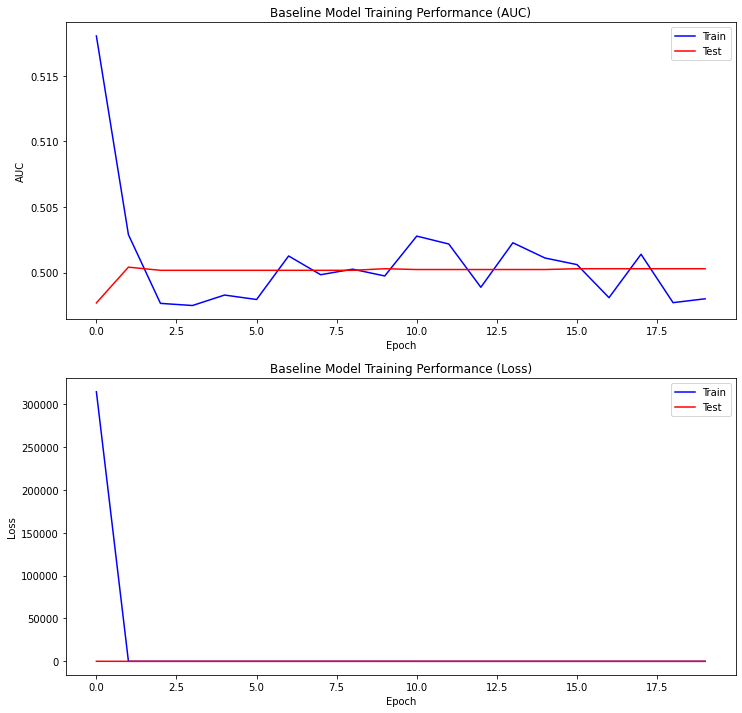

In [46]:
# Summarize model 4B training hisotry
begin_epoch = 0
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['auc'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_auc'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (AUC)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [47]:
# Define MLP model #4C
def create_model_4C():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(192, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4C = create_model_4C()
extra_epochs = 0
baseline_hist = baseline_model_4C.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 3C processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 122622 samples, validate on 21640 samples
Epoch 1/20
122622/122622 [==============================] - 15s 125us/sample - loss: 451080.1506 - auc: 0.5184 - val_loss: 345.8623 - val_auc: 0.5010
Epoch 2/20
122622/122622 [==============================] - 15s 121us/sample - loss: 123.6813 - auc: 0.5008 - val_loss: 116.7085 - val_auc: 0.4998
Epoch 3/20
122622/122622 [==============================] - 15s 119us/sample - loss: 6.4600 - auc: 0.5003 - val_loss: 85.5352 - val_auc: 0.4998
Epoch 4/20
122622/122622 [==============================] - 15s 119us/sample - loss: 0.5422 - auc: 0.4986 - val_loss: 85.5351 - val_auc: 0.4998
Epoch 5/20
122622/122622 [==============================] - 14s 118us/sample - loss: 0.5422 - auc: 0.4990 - val_loss: 85.5347 - val_auc: 0.4998
Epoch 6/20
122622/122622 [==============================] - 15s 119us/sample - loss: 0.5422 - auc: 0.4981 - val_loss: 85.5327 - val_auc: 0.4998
Epoch 7/20
122622/122622 [==============================] - 15s 119us/sample

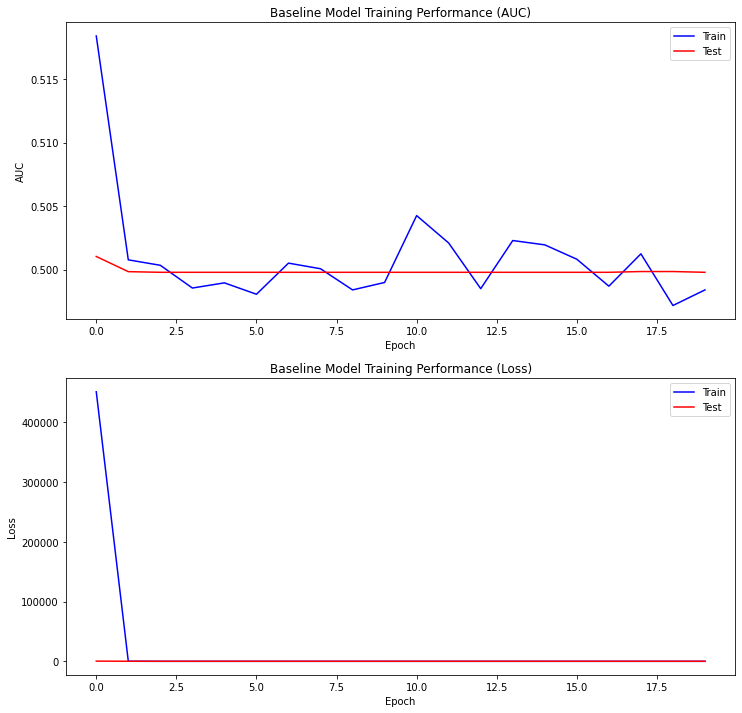

In [48]:
# Summarize model 4C training hisotry
begin_epoch = 0
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['auc'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_auc'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (AUC)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [49]:
# Define MLP model #4D
def create_model_4D():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(384, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4D = create_model_4D()
extra_epochs = 0
baseline_hist = baseline_model_4D.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 3D processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 122622 samples, validate on 21640 samples
Epoch 1/20
122622/122622 [==============================] - 15s 120us/sample - loss: 1038036.9977 - auc: 0.5153 - val_loss: 9937.9932 - val_auc: 0.4979
Epoch 2/20
122622/122622 [==============================] - 14s 114us/sample - loss: 4648.5220 - auc: 0.5153 - val_loss: 191.7259 - val_auc: 0.5010
Epoch 3/20
122622/122622 [==============================] - 14s 118us/sample - loss: 121.3637 - auc: 0.5017 - val_loss: 87.4735 - val_auc: 0.5001
Epoch 4/20
122622/122622 [==============================] - 14s 114us/sample - loss: 509.4759 - auc: 0.4990 - val_loss: 18.1942 - val_auc: 0.5001
Epoch 5/20
122622/122622 [==============================] - 14s 114us/sample - loss: 0.5423 - auc: 0.4983 - val_loss: 18.1942 - val_auc: 0.5001
Epoch 6/20
122622/122622 [==============================] - 14s 114us/sample - loss: 0.5423 - auc: 0.4982 - val_loss: 18.1942 - val_auc: 0.5001
Epoch 7/20
122622/122622 [==============================] - 14s 113us

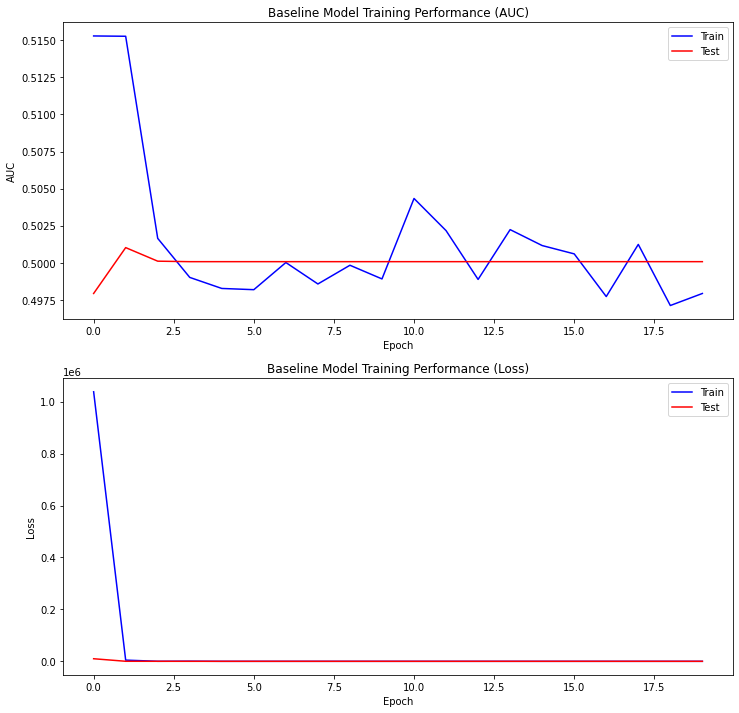

In [50]:
# Summarize model 4D training hisotry
begin_epoch = 0
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['auc'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_auc'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (AUC)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [51]:
# Define MLP model #4E
def create_model_4E():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(768, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4E = create_model_4E()
extra_epochs = 0
baseline_hist = baseline_model_4E.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 4E processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 122622 samples, validate on 21640 samples
Epoch 1/20
122622/122622 [==============================] - 15s 121us/sample - loss: 4822972.7786 - auc: 0.5136 - val_loss: 7306.4697 - val_auc: 0.5172
Epoch 2/20
122622/122622 [==============================] - 14s 114us/sample - loss: 1220.2330 - auc: 0.5031 - val_loss: 211.4270 - val_auc: 0.5006
Epoch 3/20
122622/122622 [==============================] - 14s 115us/sample - loss: 57.3952 - auc: 0.4977 - val_loss: 289.3500 - val_auc: 0.5002
Epoch 4/20
122622/122622 [==============================] - 14s 116us/sample - loss: 0.5422 - auc: 0.4970 - val_loss: 289.4514 - val_auc: 0.5002
Epoch 5/20
122622/122622 [==============================] - 14s 116us/sample - loss: 0.5422 - auc: 0.4991 - val_loss: 289.4552 - val_auc: 0.5002
Epoch 6/20
122622/122622 [==============================] - 14s 116us/sample - loss: 0.5422 - auc: 0.4987 - val_loss: 289.4563 - val_auc: 0.5002
Epoch 7/20
122622/122622 [==============================] - 14s 114u

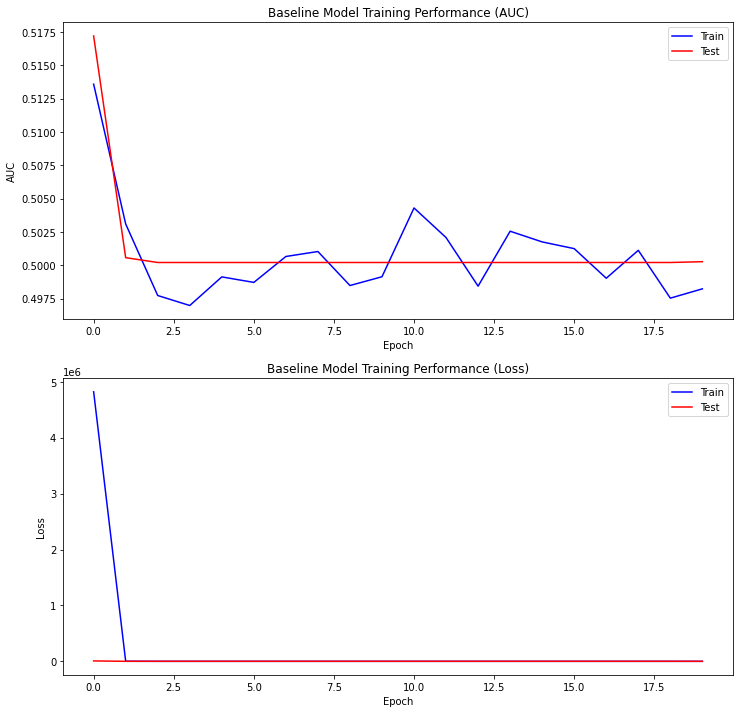

In [52]:
# Summarize model 4E training hisotry
begin_epoch = 0
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['auc'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_auc'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (AUC)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [53]:
# Define MLP model #4F
def create_model_4F():
    default_model = Sequential()
    default_model.add(Dense(2048, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1536, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_4F = create_model_4F()
extra_epochs = 0
baseline_hist = baseline_model_4F.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 4F processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 122622 samples, validate on 21640 samples
Epoch 1/20
122622/122622 [==============================] - 16s 129us/sample - loss: 11264567.7033 - auc: 0.5163 - val_loss: 11170.2578 - val_auc: 0.5104
Epoch 2/20
122622/122622 [==============================] - 15s 124us/sample - loss: 9203.7853 - auc: 0.5285 - val_loss: 3014.7914 - val_auc: 0.5005
Epoch 3/20
122622/122622 [==============================] - 15s 126us/sample - loss: 3546.6492 - auc: 0.4997 - val_loss: 1059.0671 - val_auc: 0.5003
Epoch 4/20
122622/122622 [==============================] - 15s 125us/sample - loss: 797.9699 - auc: 0.4986 - val_loss: 5419.6054 - val_auc: 0.4999
Epoch 5/20
122622/122622 [==============================] - 15s 125us/sample - loss: 332.4036 - auc: 0.4985 - val_loss: 2186.1317 - val_auc: 0.5001
Epoch 6/20
122622/122622 [==============================] - 15s 125us/sample - loss: 0.5421 - auc: 0.4999 - val_loss: 2186.1226 - val_auc: 0.5001
Epoch 7/20
122622/122622 [=============================

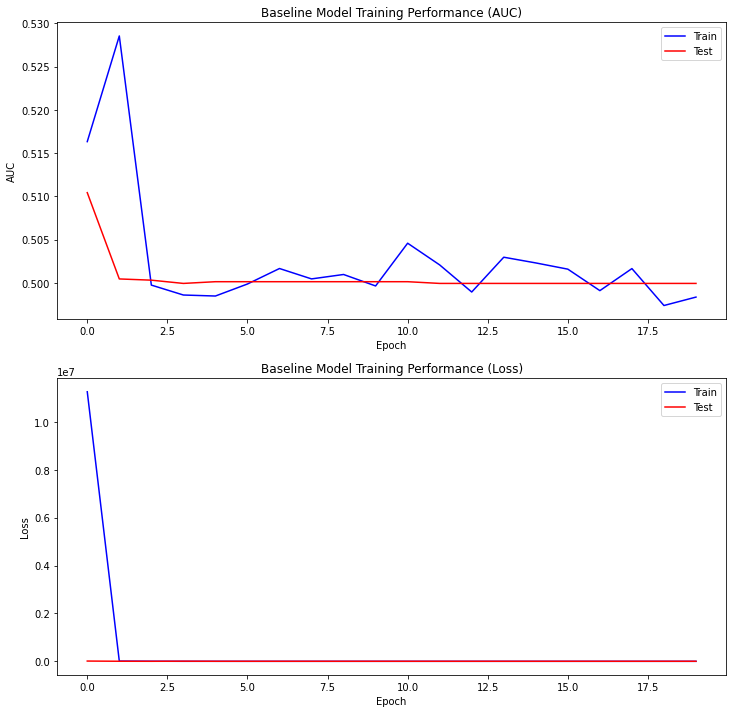

In [54]:
# Summarize model 4F training hisotry
begin_epoch = 0
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['auc'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_auc'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (AUC)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [57]:
# Display a summary of the final model
final_model = baseline_model_4A
print(final_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                131008    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 134,177
Trainable params: 134,177
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 2046), 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 48, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [60]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:30:28.999390
